## Vessel segmentation in retina images obtained via Laser Doppler Holography imaging


On dispose de vidéos de fonds de rétines obtenues par holographie digitale à partir desquelles ont souhaite récolter des informations médicales pertinentes (cycle cardiaque, resistivité, débit sanguin). Une telle vidéo est donc une suite de matrices $(I(x,y,t))_{x, y, t}$ à partir desquels on va extraire l'information. writeme : analyse qualitative des vidéos : le signal des artères est fort, on le voit pulsé, les vaisseaux de la choroide sont flous



### Sources 

- [1] Z. Jadoon et al., Retinal Blood Vessels Segmentation using ISODATA and High Boost Filter
- [2]  A. Longo et al., Assessment of hessian-based Frangi vesselness filter in optoacoustic imaging, disponible ici : https://mediatum.ub.tum.de/doc/1600558/1600558.pdf


### 1. Filtre de Frangi pour détecter les vaisseaux de la rétine

Le filtre de Frangi, proposé dans [1] et dont certains détails d'implémentation sont expliqués dans [2] est un algorithme de segmentation détectant les structures tubulaires comme les vaisseaux sanguins de la rétine. Il consiste à (1) lisser l'image en la moyennant localement avec un filtre gaussien, puis (2) à calculer la matrice hessienne de l'image en chaque pixel. Ces deux opérations peuvent être réalisées en une seule en remarquant que : 

$$ \frac{\partial^2{\left(I\ast G_{\sigma}\right)}}{\partial{x_i}\partial{x_j}} = I\ast \frac{\partial^2{G_{\sigma}}}{\partial{x_i}\partial{x_j}}  $$

où $I$ est l'image, $G_{\sigma}$ un noyau gaussien de paramètre $\sigma$, $i, j \in \{1, 2\}$ et $\ast$ est l'opération de convolution.

On calcule les valeurs propres de la hessienne en chaque pixel et on les ordonne par valeur absolue : $|\lambda_1(x, y)| \geqslant |\lambda_2(x, y)|$. 

On pose $$ \begin{align} R_b = \frac{|\lambda_1|}{|\lambda_2|} \\ 
                         S = \sqrt{\lambda_1^2 + \lambda_2^2}
            \end{align}$$

Le filtre de Frangi transforme l'image $(I(x, y))_{x, y}$ en l'image : 

$$ I_f(x, y) =  0 \text{ si } \lambda_2(x, y) = 0 \text{ et } \exp{\left(-\frac{R_b^2(x, y)}{2\alpha^2}\right)}\left(1 - \exp{\left(-\frac{S^2(x, y)}{2\beta^2}\right)} \right) \text{ sinon}$$

$\alpha$ et $\beta$ sont deux paramètres du filtre qui n'ont pas beaucoup d'influence. $\alpha$ est souvent pris égale à $1$ et $\beta = \max_{x, y}{S(x,y)}$. 

[TODO] Seuillage adaptatif


### 2. Distinguer les artères des veines, exploitation de l'anticorrelation

Le signal des artères (relié au débit sanguin) présente de grandes amplitudes comparé à celui des veines. De plus, les signaux des artères et ceux des veines sont en opposition de phase : les deux signaux sont anticorrelés. En ayant une première approximation du signal des artères $s_a(t)$, on peut donc distinguer les pixels correspondant à des veines de ceux correspondant à des artères en calculant la correlation avec $s_a(t)$ : si la correlation est positive, le pixel appartient à une artère, sinon il appartient à une veine. Comment obtenir une bonne approximation du signal présent dans les artères ? On sait qu'il présente de grandes amplitudes donc la variance est élevée pour les pixels des artères.             

In [1]:
# Libraries for imaging and linear algebra

import matplotlib.pyplot as plt
import numpy as np
import imageio
import skimage as ski
from skimage import measure

In [2]:
def frangi(I, alpha=1, beta=None, sigma=2) :
    '''This function implement the Frangi filter'''
    
    n = np.shape(I)
        
    hessian = ski.feature.hessian_matrix(I, sigma=sigma)
    
    eig_val = ski.feature.hessian_matrix_eigvals(hessian)
    mu1 = sigma**2 * eig_val[0,:,:].reshape(n)
    mu2 = sigma**2 * eig_val[1,:,:].reshape(n)
    
    lambda1 = np.zeros(n)
    lambda2 = np.zeros(n)
    
    check = abs(mu1)<abs(mu2)
    lambda1 = mu1
    lambda2 = mu2 
    lambda1[check] = mu2[check]
    lambda2[check] = mu1[check]
    
    Rb = abs(lambda1/lambda2) ** 2
    S2 = lambda1**2 + lambda2**2
    beta = np.max(S2)/2
    a, b = 2*alpha**2, 2*beta**2
    V = np.exp(-Rb/a)*(1 - np.exp(-S2/b)) 
    bsize=10
    V[:bsize,:] = 0
    V[-bsize:,:] = 0
    V[:,:bsize] = 0
    V[:,-bsize:] = 0
    #Ifiltered[lambda2<0]=0
    return V

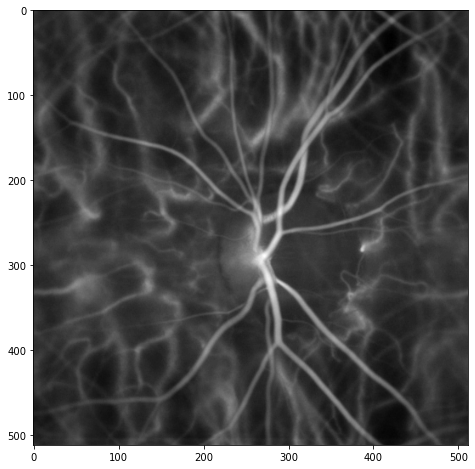

In [9]:
img = "1.png"

img = plt.imread(img)
fig=plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray")
plt.show()

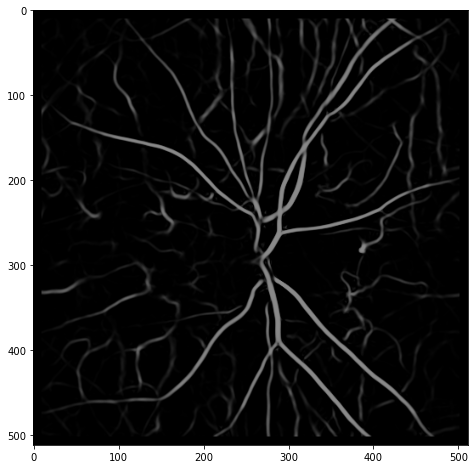

In [6]:
V = frangi(img, alpha=0.9) 
fig=plt.figure(figsize=(8,8))
plt.imshow(V, cmap="gray", vmax=1)
plt.show()